# Dane techniczne sprzętu

Obliczenia zostały wykonane na komputerze o następujących parametrach:

- Procesor: AMD Ryzen $7$ $4700$U ($8$ rdzeni, $8$ wątków),

- Pamięć RAM: $16$ GB $3200$ MHz

# Biblioteki

In [2]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Pomocnicze funkcje

## Dokładność aproksymacji

### Wykorzystane wskaźniki

Przyjmijmy następujące oznaczenia:

$f(x)$ - aproksymowana funkcja (funkcja wzorcowa)

$W(x)$ - aproksymujący wielomian algebraiczny (przybliżający funkcję wzorcową)

#### Norma z różnicy

$||f(x)-W(x)||$

In [3]:
def abs_diff(f, W, xs):
    return [abs(f(x) - W(x)) for x in xs]

#### Największa różnica

$max_k\{||f(x_k)-W(x_k)||\}$

In [4]:
def max_diff(f, W, xs):
    return max(abs_diff(f, W, xs))

#### Suma kwadratów różnic

$\sum\limits_{i = 1}^{N} (f(x_i) - W(x_i))^2$

In [5]:
def sum_sq_diff(f, W, xs):
    return sum(d ** 2 for d in abs_diff(f, W, xs))

### Funkcja służąca do wyznaczania błędów

In [6]:
def show_error(f, Ws, a, b, N, *, prec=6):
    xs = np.linspace(a, b, N)
    
    for W, label in Ws:
        diffs = abs_diff(f, W, xs)
        print(tabulate([
                ('Największy bezwzględny błąd', max(diffs)),
                ('Suma kwadratów różnic      ', sum(x ** 2 for x in diffs))
            ], [
                f'Interpolacja {label}'
            ], tablefmt='fancy_grid', floatfmt=f'.{prec}f')
        )

## Tworzenie wykresu funkcji

### Rysowanie pojedynczej funkcji na wykresie

In [7]:
def plot_fn(fn, a, b, *, label='', title='Wykres', color='b', step=.1, ax=plt):
    n = int((b - a) / step) + 1
    xs = np.linspace(a, b, n)
    ys = np.vectorize(fn)(xs)
    ax.plot(xs, ys, color, label=label)
    if label: ax.legend(loc='best')
    
    if ax is plt:
        ax.title(title)
        ax.xlabel('x')
        ax.ylabel('y')
    else:
        ax.title.set_text(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    ax.grid()
    
    sns.despine()

### Rysowanie kilku funkcji na jednym wykresie

In [8]:
class PlotFn:
    def __init__(self, f, color='b', label=''):
        self.f = f
        self.color = color
        self.label = label

def plot_fns(fns: list[PlotFn], a, b, *, title='Wykres', step=.1, ax=plt):
    for fn_obj in fns:
        plot_fn(fn_obj.f, a, b, title=title, step=step, ax=ax, color=fn_obj.color, label=fn_obj.label)

### Rysowanie wykresów funkcji i błędów

In [9]:
class PlotApprox:
    def __init__(self, approx_method, color='b', label='', args=(), kwargs={}):
        self.im = approx_method
        self.color = color
        self.label = label
        self.args = args
        self.kwargs = kwargs

def rich_plot(fn_obj: 'Funkcja wyjściowa', 
              im_objs: list[PlotApprox],
              a, b, n, *, 
              step=.01, N=1000,
              nodes_calc_method=np.linspace,
              title_comp='Porównanie z wyjściową funkcją', 
              title_err='Błędy aproksymacji',
              show_errors_details=False,
              error_prec=6):
    xs = nodes_calc_method(a, b, n)
    ys = np.vectorize(fn_obj.f)(xs)
    W_objs = [PlotFn(obj.im(xs, ys, *obj.args, **obj.kwargs), obj.color, obj.label) for obj in im_objs]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    
    # Compare approximation to the original function
    fns = [fn_obj] + W_objs
    plot_fns(fns, a, b, title=title_comp, step=step, ax=ax[0])
    ax[0].scatter(xs, ys)
    ax[0].grid(visible=True)
    
    # Create errors plot
    xs_ = np.linspace(a, b, N)
    
    for i, W_obj in enumerate(W_objs):
        diffs = abs_diff(fn_obj.f, W_obj.f, xs_)
        ax[1].scatter(xs_, diffs, s=2, c=im_objs[i].color)
    ax[1].set_title(title_err)
    ax[1].grid(visible=True)
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    
    plt.show()
    
    if show_errors_details:
        show_error(fn_obj.f, [(W.f, W.label) for W in W_objs], a, b, N, prec=error_prec)

## Wyznaczanie węzłów zgodnie z zerami wielomianu Czebyszewa

In [10]:
def chebyshev_nodes(a, b, n):
    xs = []
    for k in range(n, 0, -1):
        xs.append(.5 * (a + b) + .5 * (b - a) * math.cos((2 * k - 1) / (2 * n) * math.pi))
    return xs

# Wyznaczanie aproksymowanej funkcji

## Badana funkcja

In [11]:
f = lambda x, k, m: math.e ** (-k * math.sin(m * x)) + k * math.sin(m * x) - 1

In [12]:
a = -math.pi
b = 2 * math.pi
x = [a, b]

def g(x):
    k = 2
    m = 2
    return f(x, k, m)

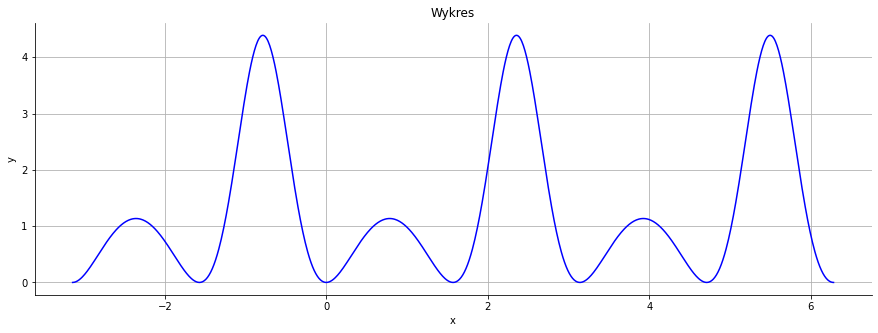

In [13]:
plt.figure(figsize=(15, 5))
plot_fn(g, a, b, step=.01)

## Aproksymacja

In [14]:
def gauss_jordan(A, B):
    n = len(B)
    
    for k in range(n):
        # Partial pivoting
        if np.fabs(A[k, k]) < 1e-12:
            for i in range(k + 1, n):
                if np.fabs(A[i, k]) > np.fabs(A[k, k]):
                    # Swap rows
                    A[[k, i]] = A[[i, k]]  
                    B[[k, i]] = B[[i, k]]
                    break
        # Division of the pivot row
        pivot = A[k, k]
        A[k] /= pivot
        B[k] /= pivot
        # Elimination loop
        for i in range(n):
            if i == k or A[i, k] == 0: continue
            factor = A[i, k]
            A[i] -= factor * A[k]
            B[i] -= factor * B[k]
            
    return B

def mean_square_approximation(xs, ys, ws: 'weights', m: 'degree of a plynomial'):
    if len(xs) != len(ys):
        raise ValueError('List of x values and list of y values must have the same length')
    
    n = len(xs)
    G = np.zeros((m, m), float)
    B = np.zeros(m, float)
    
    sums = [sum(ws[i] * xs[i] ** k for i in range(n)) for k in range(2 * m + 1)]
    
    for j in range(m):
        for k in range(m):
            G[j, k] = sums[j + k]
        
        B[j] = sum(ws[i] * ys[i] * xs[i] ** j for i in range(n))
        
    A = gauss_jordan(G, B)
    return lambda x: sum(A[i] * x ** i for i in range(m))

###### Testy

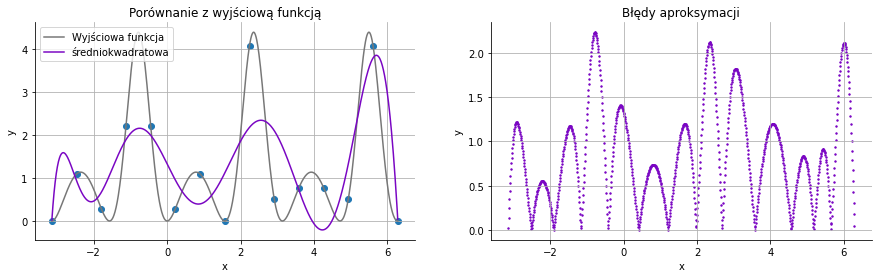

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Interpolacja średniokwadratowa │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                         2.235408 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                      1051.090595 │
╘═════════════════════════════╧══════════════════════════════════╛


In [18]:
n = 15
m = 10
ws = [1] * n  # None of the nodes is more important than the other nodes


xs = np.linspace(a, b, n)
ys = np.vectorize(g)(xs)
mean_square_approximation(xs, ys, ws, m)

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotApprox(mean_square_approximation, '#7A06C3', 'średniokwadratowa', args=(ws, m)),
    ], 
    a, b, n,
    show_errors_details=True
)

# TODO

- Dla ustalonej liczby węzłów ustalamy, jaki wielomian najlepiej aproksymuje funkcję (jak w poprzednich zadaniach),
- Dla ustalonego stopnia wielomianu, czy dodawanie węzłów polepsza wynik aproksymacji (jak wływa liczba węzłów na dokładność aprokscymacji przy ustalonym stopniu wielomianu)
- Zacząć robić wielomiany trygonometryczne